In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Thu May 28 04:51:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 27%   44C    P8     9W / 250W |  12152MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:09:00.0 Off |                  N/A |
| 37%   60C    P2    76W / 250W |    157MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import sys
import time
from functools import partial
from collections import defaultdict

import numpy as onp

import jax
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (AvgPool, BatchNorm, Conv, Dense, FanInSum,
                                   FanOut, Flatten, GeneralConv, Identity,
                                   MaxPool, Relu, LogSoftmax)

## References
- Jax ResNet50 Example: https://github.com/google/jax/blob/master/examples/resnet50.py
- Initializations: https://jax.readthedocs.io/en/latest/jax.nn.initializers.html
- jax.experimental.stax: https://jax.readthedocs.io/en/latest/_modules/jax/experimental/stax.html#Dropout
- Pytorch Models: https://pytorch.org/docs/stable/torchvision/models.html

In [5]:
import modules.utils
import modules.datasets
import config

# Find GPU Devices

In [6]:
gpus = jax.devices('gpu')
gpus

[GpuDevice(id=0)]

# Random Seed

In [7]:
random_key = random.PRNGKey(42)

# Data Handler

In [8]:
_BATCH_SIZE = 64

Files already downloaded and verified
(64, 3, 32, 32) (64, 10)


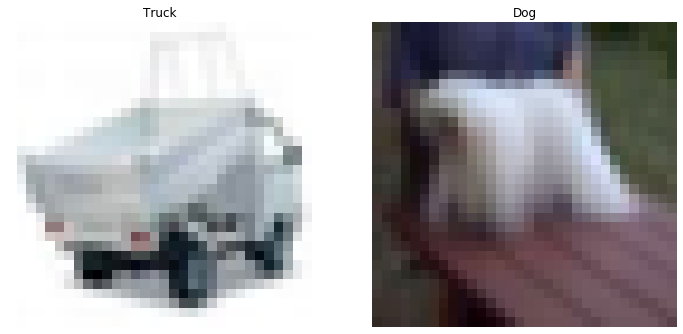

In [9]:
datahandler_key = 'pytorch' # 'pytorch', 'tensorflow'
dataset_name = "CIFAR10" # options: MNIST, CIFAR10, CIFAR100, CelebA

base_params = {
    "download_dir" : config.download_dir,
    "dataset_name" : dataset_name,
    "batch_size"   : _BATCH_SIZE,
    "flatten_img"  : False,
    "onehot_label" : True,
    "image_resize" : 224 if dataset_name == 'CelebA' else None
}
data_handler = modules.datasets.BuildDataHandler(datahandler_key, **base_params)

for x, y in data_handler('train'):
    print(x.shape, y.shape)
    break
    
modules.utils.show_samples(data_handler, 2)

# Model - Resnet

In [1]:
import modules.jax_models

In [15]:
img_format = 'NCHW'
input_shape = (_BATCH_SIZE, *data_handler.img_dim)
input_shape

(64, 3, 32, 32)

## Instantiate Model

In [17]:
init_fxn, update_fxn = modules.jax_models.ResNet18(num_classes=data_handler.num_classes, img_fmt=img_format, img_dim=input_shape[2:])
_, params = init_fxn(random_key, input_shape)

### Place on specific device

In [19]:
# Place on device
# params = jax.device_put(params, device=gpus[0])

### Check Forward Pass

In [ ]:
test_imgs = onp.random.random(size=input_shape)
test_imgs.shape

In [18]:
out = update_fxn(params, test_imgs)
out.shape

(64, 10)

## Loss Function

In [20]:
def loss_fxn(params, images, targets):
    log_softmax = update_fxn(params, images)
    return -np.sum(log_softmax*targets)

## Back Propagation

In [21]:
@jit
def update(i, params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_fxn)(params, x, y)
    opt_state = opt_update(i, grads, opt_state)
    return get_params(opt_state), opt_state, value

## Evaluation

In [22]:
def accuracy(params, data_handler, dataset_key):
    """ Compute the accuracy for a provided dataloader """
    n_batches = data_handler.num_batches(dataset_key)
    acc_total = 0
    for batch_idx, (images, targets) in enumerate(data_handler(dataset_key)):
        # Stdout
        sys.stdout.write(f'\r\tEvaluating {dataset_key} set | Batch {batch_idx+1}/{n_batches}...')
        sys.stdout.flush()
        
        # Compute target class
        target_class = np.argmax(targets, axis=1)
        
        # Model Inference
        predicted_class = np.argmax(update_fxn(params, images), axis=1)
        
        # Aggregate
        acc_total += np.sum(predicted_class == target_class)
        
    return acc_total / data_handler.size(dataset_key)

def evaluate(step_i, params, data_handler, accuracies):
    print("\nEvaluation Phase.")
    for dataset_key in ['train', 'test']:
        acc = accuracy(params, data_handler, dataset_key) 
        accuracies[dataset_key].append((step_i, acc))
    print("\n")

# Training Loop

In [23]:
def run_training_loop(data_handler, n_epochs, opt_state, eval_freq):
    """ Implements a learning loop over epochs. """
    # Metric containers
    accuracies = defaultdict(list)
    train_loss = []
    
    # Get the initial set of parameters 
    params = get_params(opt_state)
    
    # Init evaluation
    evaluate(0, params, data_handler, accuracies)
    
    # Compute num train batches
    n_train_batches = data_handler.num_batches('train')
    
    train_step_i = 0
    # Loop over the training epochs
    try:
        for epoch_i in range(n_epochs):
            epoch_loss = []
            for batch_i, (data, target) in enumerate(data_handler('train')):

                # Forward pass + Backprop 
                params, opt_state, loss_val = update(train_step_i, params, data, target, opt_state)
                train_step_i += 1
                
                # Update loss over epoch
                epoch_loss.append(loss_val)
                
                # Stdout
                stdout_str = f"\r\tTraining Phase | Epoch {epoch_i+1}/{n_epochs} -- "
                stdout_str += f"Batch {batch_i}/{n_train_batches} -- Avg Epoch Loss: {onp.mean(epoch_loss):0.2f}..."
                sys.stdout.write(stdout_str)
                sys.stdout.flush()
            
            # Update loss over training
            train_loss.append(epoch_loss)
            
            # Evaluate
            if (epoch_i+1) % eval_freq == 0:
                evaluate(epoch_i, params, data_handler, accuracies)
    except KeyboardInterrupt:
        print("\nEnding early.")
    
    return train_loss, accuracies, params

In [24]:
_LEARNING_RATE = 1e-3

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(_LEARNING_RATE)
# opt_init, opt_update, get_params = optimizers.momentum(_LEARNING_RATE, mass=0.9)
opt_state = opt_init(params)

In [25]:
_N_EPOCHS = 4
_EVAL_FREQ = 1

run_vals = run_training_loop(data_handler, _N_EPOCHS, opt_state, _EVAL_FREQ)
train_loss, accuracies, params = run_vals


Evaluation Phase.
	Evaluating test set | Batch 157/157....

	Training Phase | Epoch 1/4 -- Batch 781/782 -- Loss: 92.01....
Evaluation Phase.
	Evaluating test set | Batch 157/157....

	Training Phase | Epoch 2/4 -- Batch 781/782 -- Loss: 66.95...
Evaluation Phase.
	Evaluating test set | Batch 157/157....

	Training Phase | Epoch 3/4 -- Batch 781/782 -- Loss: 55.13...
Evaluation Phase.
	Evaluating test set | Batch 157/157....

	Training Phase | Epoch 4/4 -- Batch 781/782 -- Loss: 47.69...
Evaluation Phase.
	Evaluating test set | Batch 157/157....



In [ ]:
modules.utils.plot_metrics(train_loss, accuracies)

# Visual Eval

In [ ]:
samples, accuracies = modules.utils.generate_samples(update_fxn, params, data_handler)

In [ ]:
modules.utils.show_predictions(samples, accuracies, data_handler) 